### Importing Required Packages

In [135]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math

### Defining Functions

In [80]:
# Shuffling the Dataset
def shuffle_dataset(dataset):
    shuffled_dataset = dataset.sample(frac=1)
    return shuffled_dataset

# Building Generators
def build_generators(dataset, train_size=0.8, batch_size=64):
    train_split = math.ceil(dataset.shape[0] * train_size)
    train_data_tuple = (dataset.iloc[:train_split, 0].values, dataset.iloc[:train_split, 1].values)
    train_dataset = tf.data.Dataset.from_tensor_slices(train_data_tuple).batch(batch_size)
    test_data_tuple = (dataset.iloc[train_split:, 0].values, dataset.iloc[train_split:, 1].values)
    test_dataset = tf.data.Dataset.from_tensor_slices(test_data_tuple).batch(batch_size)
    return train_dataset, test_dataset

# Building and Adapting Text Encoder
def build_text_encoder(dataset, vocab_size=10000, ngrams=2, sequence_length=None):
    encoder = layers.TextVectorization(max_tokens=vocab_size, ngrams=ngrams, output_sequence_length=sequence_length)
    encoder.adapt(dataset.map(lambda text, label: text))
    return encoder

# Optimizing Generators
def optimize_generator(dataset):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# Building the Model
def build_model(encoder, embedding_dim=32):
    vocab_size = len(encoder.get_vocabulary())
    model = Sequential([encoder,
                        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True),
                        layers.GlobalAveragePooling1D(),
                        layers.Dropout(0.5),
                        layers.Dense(3, activation="softmax")])
    return model

# Visualizing the Model
sns.set_theme()
def visualize_model(history):
    plt.figure(figsize=(12, 8))
    for index, metric in enumerate(["accuracy", "loss"]):
        plt.subplot(1, 2, index + 1)
        plt.plot(history[metric], label=metric)
        plt.plot(history[f"val_{metric}"], label=f"val_{metric}")
        plt.legend(loc="best")
    plt.show()

# Predicting with Model
def predict(sentence, model):
    classes = ["None", "Racism", "Xenephobic"]
    prediction = model.predict([sentence], verbose=0)
    return {
        classes[1]: prediction[0, 1],
        classes[2]: prediction[0, 2],
        classes[0]: prediction[0, 0]
    }

### Finding the Best Dataset and Model

In [38]:
# Reading csv file
df = pd.read_csv("./RacismXenephobicDataset.csv")
# Finding best model by sampling from dataframe
max_accuracy = 0
for i in range(20):
    df = shuffle_dataset(df)
    raw_train_dataset, raw_test_dataset = build_generators(df)
    encoder = build_text_encoder(raw_train_dataset)
    raw_train_dataset = optimize_generator(raw_train_dataset)
    raw_test_dataset = optimize_generator(raw_test_dataset)
    model = build_model(encoder)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    history = model.fit(raw_train_dataset,
                        validation_data=raw_test_dataset,
                        epochs=100,
                        verbose=0)
    accuracy = model.evaluate(raw_test_dataset, verbose=0)[1]
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        model.save("best_model.tf", save_format="tf")
        df.to_csv("best_dataset.csv", index=False)
        pd.DataFrame(history.history).to_csv("best_model_history.csv", index=False)
        print(f"Model {i + 1} from 20: {accuracy:.2%}")

INFO:tensorflow:Assets written to: best_model.tf\assets


INFO:tensorflow:Assets written to: best_model.tf\assets


Model 1 from 20: 79.45%
INFO:tensorflow:Assets written to: best_model.tf\assets


INFO:tensorflow:Assets written to: best_model.tf\assets


Model 2 from 20: 80.95%
INFO:tensorflow:Assets written to: best_model.tf\assets


INFO:tensorflow:Assets written to: best_model.tf\assets


Model 4 from 20: 81.70%
INFO:tensorflow:Assets written to: best_model.tf\assets


INFO:tensorflow:Assets written to: best_model.tf\assets


Model 6 from 20: 83.46%
INFO:tensorflow:Assets written to: best_model.tf\assets


INFO:tensorflow:Assets written to: best_model.tf\assets


Model 10 from 20: 83.96%
INFO:tensorflow:Assets written to: best_model.tf\assets


INFO:tensorflow:Assets written to: best_model.tf\assets


Model 12 from 20: 85.46%


### Loading the Best Dataset

In [133]:
# Reading csv file
df = pd.read_csv("./best_dataset.csv")
df.head()

,Comment,Label
0,@user i c sociopaths low iq satanic everything...,0
1,I hate darkskin pussy its dark on outside and ...,1
2,"Dear women, stop saying you have pure intentio...",0
3,religions stunt kid's development,1
4,Zionists are dishonest people,1


### Building Train, Validation and Test Generators

In [82]:
raw_train_dataset, raw_test_dataset = build_generators(df)

### Defining Text Encoder

In [92]:
encoder = build_text_encoder(raw_train_dataset)
vocab = encoder.get_vocabulary()
print(vocab)

['', '[UNK]', 'the', 'are', 'to', 'a', 'i', 'is', 'of', 'and', 'people', 'black', 'you', 'in', 'that', 'not', 'all', 'it', 'this', 'be', 'they', 'so', 'if', 'white', 'for', 'my', 'like', 'hate', 'women', 'think', 'do', 'with', 'why', 'would', 'have', 'black people', 'fucking', 'we', 'should', 'i hate', 'country', 'as', 'shit', 'your', 'no', 'just', 'dont', 'up', 'its', 'on', 'what', 'society', 'at', 'get', 'can', 'will', 'our', 'people are', 'if you', 'are the', 'of the', 'about', 'always', 'there', 'them', 'real', 'love', 'in the', 'out', 'was', 'im', 'but', 'us', 'muslims', 'me', 'fuck', 'from', 'nigger', 'good', 'an', 'you think', 'this country', 'need', 'he', 'when', 'to society', 'the real', 'one', 'dark', 'why are', 'want', 'most', 'i think', 'would agree', 'should be', 'only', 'agree that', 'agree', 'zionists', 'women are', 'who', 'their', 'men', 'how', 'a black', 'these', 'look', 'person', 'cant', 'shot', 'is not', 'disgusting', 'back', 'are a', 'of a', 'is the', 'by', 'blacks'

### Configuring the Dataset for Performance

In [93]:
raw_train_dataset = optimize_generator(raw_train_dataset)
raw_test_dataset = optimize_generator(raw_test_dataset)

### Loading the Model

In [94]:
model = load_model("best_model.tf")

In [95]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_32 (Tex  (None, None)              0         
 tVectorization)                                                 
                                                                 
 embedding_31 (Embedding)    (None, None, 32)          320000    
                                                                 
 global_average_pooling1d_3  (None, 32)                0         
 1 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 3)                 99        
                                                                 
Total params: 320099 (1.22 MB)
Trainable params: 3200

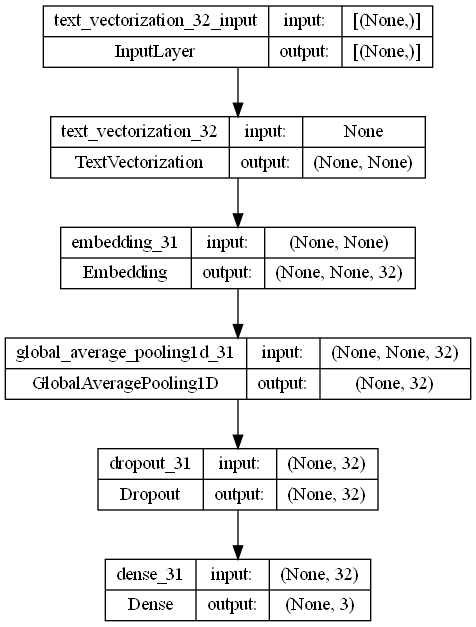

In [96]:
keras.utils.plot_model(model, show_shapes=True)

### Evaluating the Model

In [97]:
model.evaluate(raw_test_dataset, verbose=1)

7/7 [==============================] - 0s 3ms/step - loss: 0.4103 - accuracy: 0.8546


[0.4103361666202545, 0.8546366095542908]

### Visualizing the Model

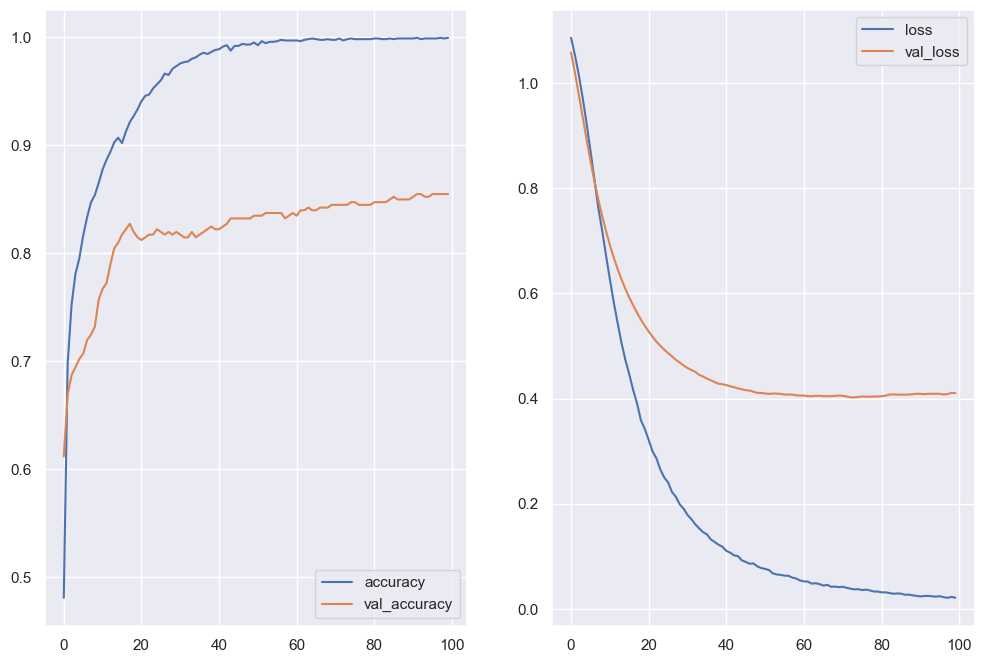

In [98]:
history = pd.read_csv("best_model_history.csv")
visualize_model(history)

### Predicting with Model

In [90]:
sentence = input("Please enter comment: ")
t1 = time.time()
prediction = predict(sentence, model)
t2 = time.time()
print(sentence)
print("*" * 30)
for key, value in prediction.items():
    print(f"{key}: {value:.2%}")
print("*" * 30)
print(f"Inference Time: {(t2 - t1):.2f} second")

Arabs are a threat to our society
******************************
Racism: 0.73%
Xenephobic: 97.05%
None: 2.22%
******************************
Inference Time: 0.19 second


### Rebuild the Best Model with Different Hyperparameters

In [106]:
# Changing vocab_size and ngrams
encoder = build_text_encoder(raw_train_dataset, vocab_size=30000, ngrams=3)
model = build_model(encoder)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# Defining early stopping callback
early_stop = EarlyStopping(monitor="val_loss", patience=20)
history = model.fit(raw_train_dataset,
                    validation_data=raw_test_dataset,
                    epochs=100,
                    callbacks=[early_stop])

Epoch 1/100
25/25 [==============================] - 2s 28ms/step - loss: 1.0878 - accuracy: 0.5106 - val_loss: 1.0788 - val_accuracy: 0.5739
Epoch 2/100
25/25 [==============================] - 0s 17ms/step - loss: 1.0528 - accuracy: 0.7706 - val_loss: 1.0518 - val_accuracy: 0.6341
Epoch 3/100
25/25 [==============================] - 0s 16ms/step - loss: 1.0123 - accuracy: 0.8138 - val_loss: 1.0210 - val_accuracy: 0.6692
Epoch 4/100
25/25 [==============================] - 0s 19ms/step - loss: 0.9643 - accuracy: 0.8413 - val_loss: 0.9866 - val_accuracy: 0.6892
Epoch 5/100
25/25 [==============================] - 0s 17ms/step - loss: 0.9091 - accuracy: 0.8481 - val_loss: 0.9495 - val_accuracy: 0.7118
Epoch 6/100
25/25 [==============================] - 0s 16ms/step - loss: 0.8487 - accuracy: 0.8569 - val_loss: 0.9113 - val_accuracy: 0.7368
Epoch 7/100
25/25 [==============================] - 0s 18ms/step - loss: 0.7872 - accuracy: 0.8650 - val_loss: 0.8729 - val_accuracy: 0.7444
Epoch 

### Visualizing the Model

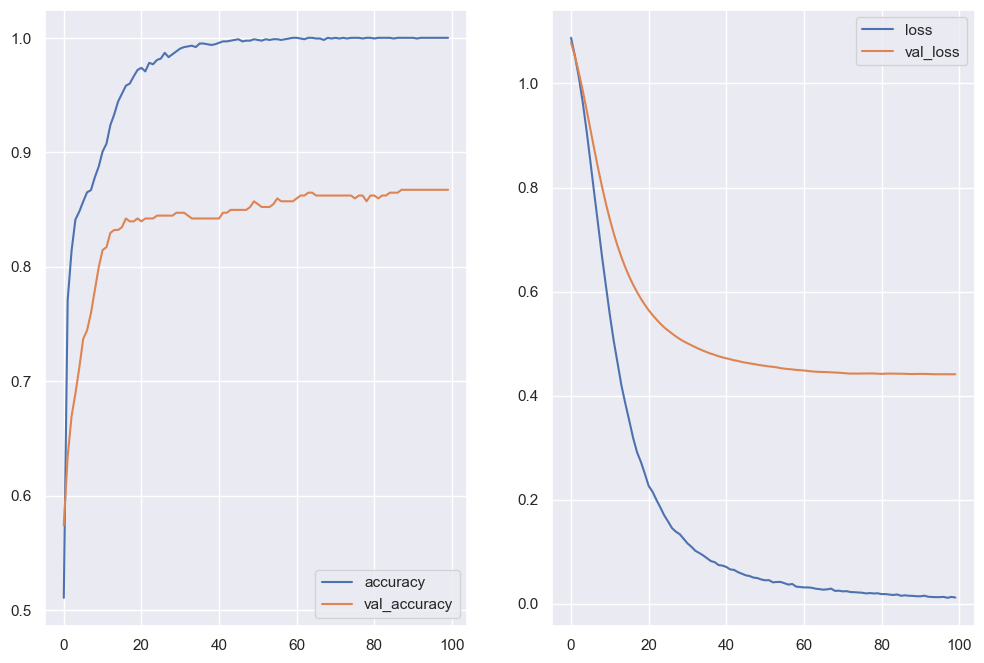

In [185]:
visualize_model(history.history)

### Evaluating the Model

In [113]:
model.evaluate(raw_test_dataset, verbose=1)

7/7 [==============================] - 0s 4ms/step - loss: 0.4411 - accuracy: 0.8672


[0.44106513261795044, 0.8671678900718689]

### Predicting with Model

In [131]:
sentence = input("Please enter comment: ")
t1 = time.time()
prediction = predict(sentence, model)
t2 = time.time()
print(sentence)
print("*" * 30)
for key, value in prediction.items():
    print(f"{key}: {value:.2%}")
print("*" * 30)
print(f"Inference Time: {(t2 - t1):.2f} second")

Blacks should be sent back to africa
******************************
Racism: 27.51%
Xenephobic: 72.24%
None: 0.25%
******************************
Inference Time: 0.10 second


### Calculating Model Metrics

accuracy = 86.72%
precision = 86.77%
recall = 85.16%
f1 = 85.90%



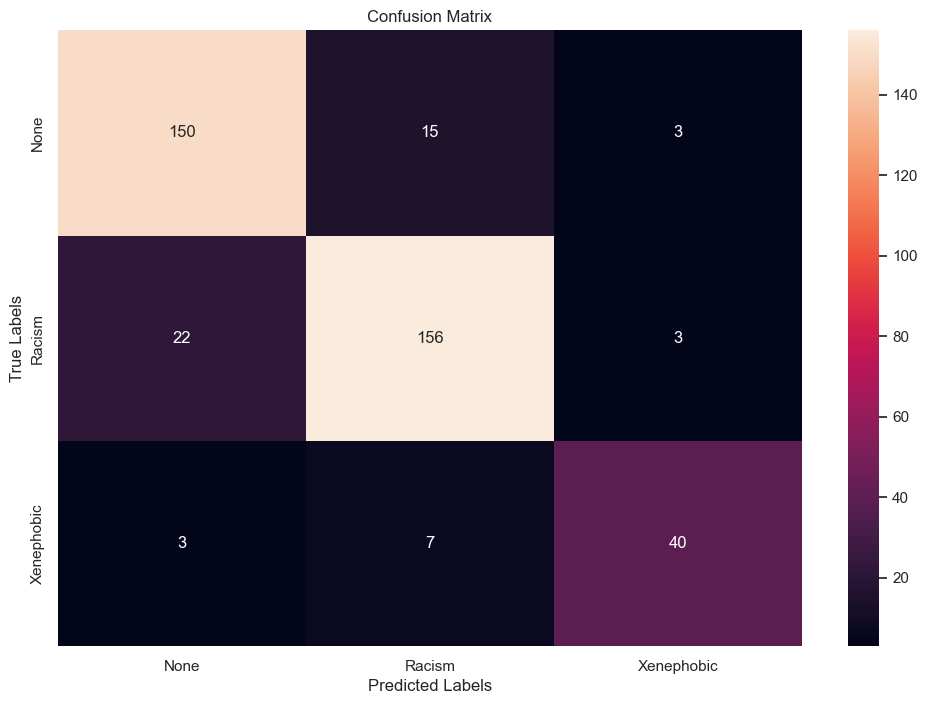

In [193]:
y_prediction = np.argmax(model.predict(raw_test_dataset, verbose=0), axis=-1) 
y_test = df.iloc[1600:, 1].values
accuracy = metrics.accuracy_score(y_test, y_prediction)
precision = metrics.precision_score(y_test, y_prediction, average="macro")
recall = metrics.recall_score(y_test, y_prediction, average="macro")
f1 = metrics.f1_score(y_test, y_prediction, average="macro")
confusion_matrix = metrics.confusion_matrix(y_test, y_prediction)
print(f"{accuracy = :.2%}\n{precision = :.2%}\n{recall = :.2%}\n{f1 = :.2%}\n")
plt.figure(figsize=(12, 8))
ax = sns.heatmap(confusion_matrix, annot=True, fmt="g")
ax.set_title("Confusion Matrix")
ax.set_ylabel("True Labels")
ax.set_xlabel("Predicted Labels")
ax.set_xticklabels(["None", "Racism", "Xenephobic"])
ax.set_yticklabels(["None", "Racism", "Xenephobic"])
plt.show()

### Saving the Final Model

In [195]:
pd.DataFrame(history.history).to_csv("final_model_history.csv", index=False)
model.save("final_model.tf", save_format="tf")

INFO:tensorflow:Assets written to: final_model.tf\assets


INFO:tensorflow:Assets written to: final_model.tf\assets
